In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=d51833da2d518775706f0d1acb7d544f142861ca98dc1fa2f30ce0c0fa6952f2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Importing necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline # pipeline to transform data
from pyspark.sql import SparkSession # to initiate spark
from pyspark.sql.types import FloatType
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.sql.functions import concat_ws, col # to concatinate cols
from pyspark.ml.classification import LogisticRegression # ml model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model
from pyspark.mllib.evaluation import MulticlassMetrics # # performance metrics

In [3]:
# create a new spark session
spark = SparkSession.builder.appName("song_classfier")\
                            .getOrCreate()

# show session details
spark

In [7]:
# load dataset
df = spark.read.csv("/content/tcc_ceds_music.csv", inferSchema=True, header=True)

# shows top 20 rows
df.show()

+---+--------------------+--------------------+------------+-----+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------+
|_c0|         artist_name|          track_name|release_date|genre|              lyrics|len|              dating|            violence|          world/life|          night/time|  shake the audience|       family/gospel|            romantic|       communication|             obscene|               music|     movement/places|light/visual perceptions|    family/spiritual|          like/girls|             sadness|       

In [8]:
from pyspark.sql.functions import col, count

# You can use df.groupBy() and count() to get genre counts
genre_counts = df.groupBy("genre").agg(count("*").alias("count"))

# Show the resulting DataFrame
genre_counts.show()

+-------+-----+
|  genre|count|
+-------+-----+
|    pop| 7042|
|  blues| 4604|
|country| 5445|
|   jazz| 3845|
|hip hop|  904|
|   rock| 4034|
| reggae| 2498|
+-------+-----+



In [9]:
from pyspark.ml.feature import StringIndexer

# Sample DataFrame with a "category" column
data = [(0, "pop"),
        (1, "blues"),
        (2, "country"),
        (3, "jazz"),
        (4, "hip hop"),
        (5, "rock"),
        (6, "reggae"),]



In [14]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer,Word2Vec
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import concat, col

# regular expression tokenizer
# Concatenate the 'artist_name', 'track_name', and 'lyrics' columns into a new column 'new_ly'
df = df["artist_name","track_name","release_date","genre","lyrics"]
# df = df.withColumn("new_ly", concat(col("artist_name"),  col("track_name"), col("lyrics")))


regexTokenizer = RegexTokenizer(inputCol="lyrics", outputCol="words", pattern="\\W")
# to remove stop words like is, the, in, etc.
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="stopwords_remove")
# bag of words count
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="stopwords_remove", outputCol="features")

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

label_stringIdx = StringIndexer(inputCol = "genre", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwords_remover, word2Vec, label_stringIdx])
# Fit the pipeline to training documents.



pipelineFit = pipeline.fit(df)
dataset = pipelineFit.transform(df)
dataset.show(5)

+--------------------+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-----+
|         artist_name|          track_name|release_date|genre|              lyrics|               words|    stopwords_remove|            features|label|
+--------------------+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-----+
|              mukesh|mohabbat bhi jhoothi|        1950|  pop|hold time feel br...|[hold, time, feel...|[hold, time, feel...|[-0.0602561402036...|  0.0|
|       frankie laine|           i believe|        1950|  pop|believe drop rain...|[believe, drop, r...|[believe, drop, r...|[-0.0593923533668...|  0.0|
|         johnnie ray|                 cry|        1950|  pop|sweetheart send l...|[sweetheart, send...|[sweetheart, send...|[-0.0110573951775...|  0.0|
|         pérez prado|            patricia|        1950|  pop|kiss lips want st...

In [40]:
pipelineFit.save("my_pipeline")

In [41]:
!zip -r /content/pipeline.zip /content/my_pipeline

  adding: content/my_pipeline/ (stored 0%)
  adding: content/my_pipeline/metadata/ (stored 0%)
  adding: content/my_pipeline/metadata/_SUCCESS (stored 0%)
  adding: content/my_pipeline/metadata/.part-00000.crc (stored 0%)
  adding: content/my_pipeline/metadata/._SUCCESS.crc (stored 0%)
  adding: content/my_pipeline/metadata/part-00000 (deflated 24%)
  adding: content/my_pipeline/stages/ (stored 0%)
  adding: content/my_pipeline/stages/3_StringIndexer_5395dd103fc5/ (stored 0%)
  adding: content/my_pipeline/stages/3_StringIndexer_5395dd103fc5/data/ (stored 0%)
  adding: content/my_pipeline/stages/3_StringIndexer_5395dd103fc5/data/_SUCCESS (stored 0%)
  adding: content/my_pipeline/stages/3_StringIndexer_5395dd103fc5/data/part-00000-c1c1e68c-a69a-452e-8951-a174782c9c34-c000.snappy.parquet (deflated 33%)
  adding: content/my_pipeline/stages/3_StringIndexer_5395dd103fc5/data/._SUCCESS.crc (stored 0%)
  adding: content/my_pipeline/stages/3_StringIndexer_5395dd103fc5/data/.part-00000-c1c1e68c-

In [16]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 22716
Test Dataset Count: 5656


In [17]:
trainingData.show(10)

+--------------------+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-----+
|         artist_name|          track_name|release_date|genre|              lyrics|               words|    stopwords_remove|            features|label|
+--------------------+--------------------+------------+-----+--------------------+--------------------+--------------------+--------------------+-----+
|"""weird al"" yan...|(this song's just...|        1988|  pop|song word long so...|[song, word, long...|[song, word, long...|[-0.1634306071191...|  0.0|
|"""weird al"" yan...|   addicted to spuds|        1986|  pop|potato skin potat...|[potato, skin, po...|[potato, skin, po...|[0.01976571031627...|  0.0|
|"""weird al"" yan...|christmas at grou...|        1986|  pop|christmas grind z...|[christmas, grind...|[christmas, grind...|[0.05538081125424...|  0.0|
|"""weird al"" yan...|       good old days|        1988|  pop|time think younge...

In [18]:
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial")
lrModel = lr.fit(trainingData)


In [19]:
lrModel.save('my_model')

In [20]:
!zip -r /content/model.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/data/ (stored 0%)
  adding: content/my_model/data/_SUCCESS (stored 0%)
  adding: content/my_model/data/.part-00000-f7588e9b-7de1-4341-a3a9-bec47551a653-c000.snappy.parquet.crc (stored 0%)
  adding: content/my_model/data/part-00000-f7588e9b-7de1-4341-a3a9-bec47551a653-c000.snappy.parquet (deflated 31%)
  adding: content/my_model/data/._SUCCESS.crc (stored 0%)
  adding: content/my_model/metadata/ (stored 0%)
  adding: content/my_model/metadata/_SUCCESS (stored 0%)
  adding: content/my_model/metadata/.part-00000.crc (stored 0%)
  adding: content/my_model/metadata/._SUCCESS.crc (stored 0%)
  adding: content/my_model/metadata/part-00000 (deflated 45%)


In [35]:
lyricss = "burn letter write break promise speak swallow pride till think choke give bout give bout want somebody guess heart come true fake give bout give bout cry milk spill dance waltz stand time precious kill give bout give bout want somebody guess heart come true fake give bout give bout give bout "

new_df = spark.createDataFrame([(lyricss,)], ["lyrics"])
p = pipelineFit.transform(new_df)


In [36]:
p.show()

+--------------------+--------------------+--------------------+--------------------+
|              lyrics|               words|    stopwords_remove|            features|
+--------------------+--------------------+--------------------+--------------------+
|burn letter write...|[burn, letter, wr...|[burn, letter, wr...|[-0.0723639201415...|
+--------------------+--------------------+--------------------+--------------------+



In [37]:
pred = lrModel.transform(p)

In [39]:
pred.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              lyrics|               words|    stopwords_remove|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|burn letter write...|[burn, letter, wr...|[burn, letter, wr...|[-0.0723639201415...|[1.13033663245376...|[0.29912932112376...|       0.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



In [22]:
predictions = lrModel.transform(testData)

In [23]:
predictions.filter(predictions['prediction'] == 1) \
    .select("lyrics","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+-----+----------+
|                        lyrics|                   probability|label|prediction|
+------------------------------+------------------------------+-----+----------+
|hear wind sing song know le...|[0.3538689472774823,0.36687...|  0.0|       1.0|
|young foolish wrong young f...|[0.34917917976582763,0.3644...|  4.0|       1.0|
|goddamn room hazy afternoon...|[0.33957009704410107,0.3720...|  3.0|       1.0|
|walk street start time meet...|[0.33917933481283435,0.4042...|  2.0|       1.0|
|darling know silence prove ...|[0.3329452299142029,0.34649...|  1.0|       1.0|
|sista manchesta come carife...|[0.3325041468776568,0.35876...|  5.0|       1.0|
|everybody wanna livin limel...|[0.3303739203310126,0.34402...|  1.0|       1.0|
|wonder long heart break wat...|[0.32953493872616385,0.3455...|  0.0|       1.0|
|remember remember wanna kno...|[0.3271283867022507,0.37962...|  0.0|       1.0|
|smile little harder laugh l

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.34412308238499506

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Assuming you have a multiclass classification model and predictions
# 'predictions' is a DataFrame with 'label' and 'prediction' columns

# Initialize a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate the model using the evaluator
accuracy = evaluator.evaluate(predictions)  # You can use other metrics such as "f1", "weightedPrecision", "weightedRecall", etc.
print(f"Accuracy: {accuracy:.2%}")

# Create a RDD of (prediction, label) pairs for MulticlassMetrics
predictionAndLabels = predictions.select("prediction", "label").rdd

# Initialize MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 34.41%


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[862. 240.  80. 100.  65.  40.  40.]
 [357. 524.  94.  36.  37.  14.   4.]
 [351. 226. 171.  70.  56.  32.   8.]
 [335. 133.  69. 201.  36.  25.   7.]
 [351. 130.  57.  65. 137.  33.  15.]
 [209.  61.  37.  36.  20. 114.   7.]
 [ 93.   3.   6.   7.   3.   6.  53.]]


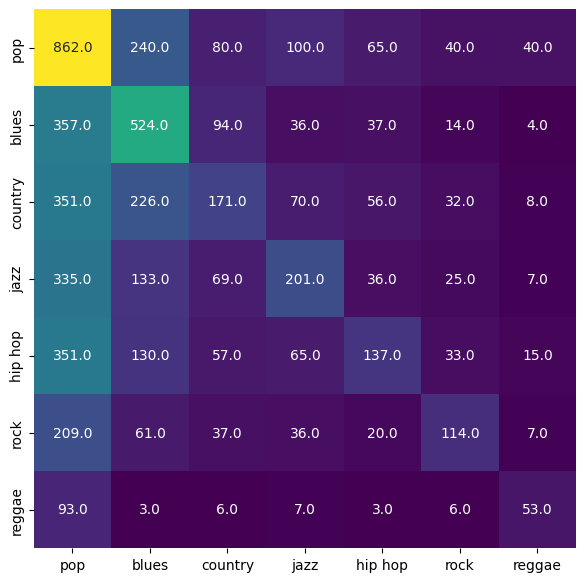

In [26]:
labels = ["pop", "blues","country","jazz","hip hop","rock","reggae"]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']) \
                              .withColumn('label', col('label') \
                              .cast(FloatType())) \
                              .orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.show()

In [20]:
predictions.show()

+---+-------------------+--------------------+------------+-----+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|_c0|        artist_name|          track_name|release_date|genre|              lyrics|len|              dating|            violence|          world/life|          night/time|  shake the audience|       family/gospel|            romantic|       communication|             obsc